In [1]:
import sys
sys.path.insert(0, "../")
from tmds import *
import os
%matplotlib inline

2.7.12 (default, Nov 12 2018, 14:36:49) 
[GCC 5.4.0 20160609]


In [2]:
from sklearn.preprocessing import StandardScaler as SS
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.utils import resample
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder

In [3]:
s = ["CHA", "SFA-Ctk", "SFA-Pw", "SHA-Ctk", "SHA-Pw", "SRHA"]
cities = ["a", "b", "c", "d", "e"]

In [6]:
df = pd.read_csv("data.csv", "\t")
df["abundance"] = np.log(df["abundance"])
df["H/C"] = df["H"] / df["C"]
df["O/C"] = df["O"] / df["C"]
df["DBE"] = df["C"] - df["H"]/2 + df["N"]/2 + 1
df.sample(10)

,exp,town,abundance,mw,error,C,H,O,N,S,y,H/C,O/C,DBE
29811,SFA-Ctk,a,-5.293983,456.084496,-0.047524,26,16,8,0,0,3,0.615385,0.307692,19.0
90232,SHA-Ctk,e,-2.231810,334.063016,0.065098,23,10,3,0,0,3,0.434783,0.130435,19.0
76226,SFA-Pw,e,-3.646995,704.137866,0.185704,35,28,16,0,0,3,0.800000,0.457143,22.0
111976,SHA-Pw,e,-4.006754,591.043916,0.238334,31,13,12,1,0,1,0.419355,0.387097,26.0
51091,SFA-Pw,a,-5.100822,478.085956,-0.038338,20,18,12,2,0,4,0.900000,0.600000,13.0
20927,CHA,e,-3.286848,479.027846,0.239932,26,9,9,1,0,4,0.346154,0.346154,23.0
61576,SFA-Pw,b,-3.858912,466.199166,0.026699,27,30,7,0,0,4,1.111111,0.259259,13.0
29855,SFA-Ctk,a,-5.189236,463.184256,0.052234,23,29,9,1,0,5,1.260870,0.391304,10.0
21589,CHA,e,-3.116009,470.151786,-0.049637,32,22,4,0,0,1,0.687500,0.125000,22.0
102116,SHA-Pw,c,-2.238770,448.058196,-0.238556,27,12,7,0,0,5,0.444444,0.259259,22.0


In [7]:
db = pd.get_dummies(df[["town", "abundance", "H/C", "O/C", "N", "S", "DBE", "mw", "error", "y"]])
db["exp"] = df["exp"]
db["y"] = (db["y"] >= 3) * 1
db["town"] = df["town"]
db.sample(5)

,abundance,H/C,O/C,N,S,DBE,mw,error,y,town_a,town_b,town_c,town_d,town_e,exp,town
59248,-6.718594,0.461538,0.384615,0,0,21.0,484.043036,-0.022327,0,1,0,0,0,0,SFA-Pw,a
7915,-6.192458,0.370370,0.333333,0,0,23.0,478.032416,-0.138260,1,0,1,0,0,0,CHA,b
76572,-2.779681,0.571429,0.761905,0,0,16.0,520.012576,0.079523,1,0,0,0,0,1,SFA-Pw,e
137693,-1.540484,0.666667,0.375000,0,0,17.0,448.079476,0.097494,1,0,0,0,0,1,SRHA,e
117633,-2.726250,1.120000,0.520000,0,0,12.0,536.152996,0.008731,1,1,0,0,0,0,SRHA,a


In [8]:
len(db)

138385

In [7]:
db.exp.unique()
#['CHA', 'SFA-Ctk', 'SFA-Pw', 'SHA-Ctk', 'SHA-Pw', 'SRHA']
#I will not use CHA, SHA-Ctk
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
model = Pipeline([("ss", SS()), ("svm", LR())])

ans = []

for i in range(4):
    train = filter(lambda x: x != exps[i], exps)
    train = pd.concat(list(map(lambda x: db[db["exp"] == x], train)))
    
    one = train[train["y"] == 1]
    zer = train[train["y"] == 0]
    print(len(one))
    print(len(zer))
    tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
    
    
    test = db[db["exp"] == exps[i]]
    
    print "fitting..."
    model.fit(tr.drop(["y", "exp"], axis=1), tr["y"])
    print "scoring..."
    print exps[i]
    
    ans.append(model.predict(test.drop(["y", "exp"], axis=1)))
    
    
    print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp"], axis=1)), tr["y"])
    print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp"], axis=1)), train["y"])
    print "test:            ", f1_score(ans[-1], test["y"])
    
    
    

48326
26986
fitting...
scoring...
SFA-Ctk
balanced train:   0.790131612903
unbalanced train: 0.828478964401
test:             0.832821534291
47070
26046
fitting...
scoring...
SFA-Pw
balanced train:   0.77296849792
unbalanced train: 0.814590277622
test:             0.818545208873
52615
28571
fitting...
scoring...
SHA-Pw
balanced train:   0.800075219783
unbalanced train: 0.841204092729
test:             0.640091820068
50772
30378
fitting...
scoring...
SRHA
balanced train:   0.791093814171
unbalanced train: 0.827608077419
test:             0.845289148798


In [8]:
db["y_pred"] = 0
for i in range(4):
    db.loc[db["exp"] == exps[i], "y_pred"] = ans[i]

In [9]:
data_1 = []
for i in range(4):
    data_1.append([])
    for j in range(5):
        data_1[-1].append(get_set_of_tuples_from_np(df[(df["exp"] == exps[i]) & (db["y"] == 1) & (df["town"] == cities[j])][elems].values))

In [10]:
for i in range(4):
    for j in range(5):
        print len(data_1[i][j])

4403
2233
2533
4435
4331
4487
3788
2962
4132
3822
2313
2444
2650
3044
3195
3386
3552
1499
3741
3311


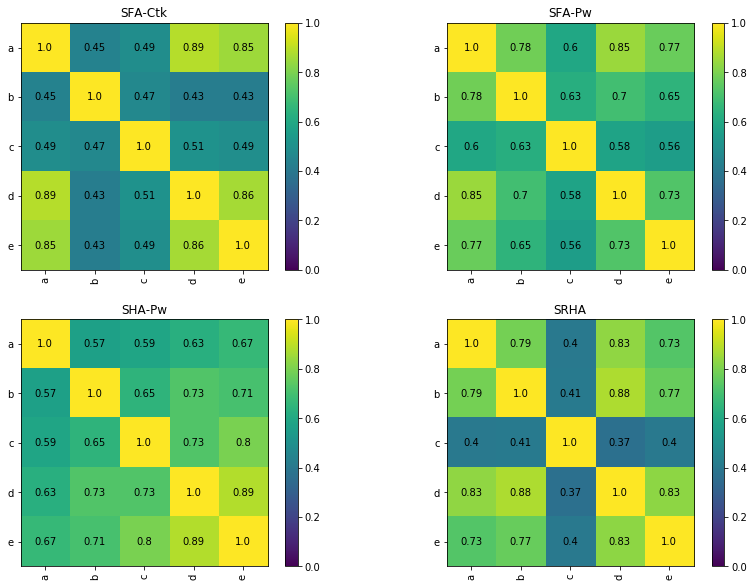

In [11]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_1[e][i], data_1[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [12]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

In [13]:
data = []
for i in range(4):
    data.append([])
    for j in range(5):
        data[-1].append(get_set_of_tuples_from_np(df[(df["exp"] == exps[i]) & 
                                                             (df["town"] == cities[j]) & 
                                                             (df["y"] > 0)][elems].values))

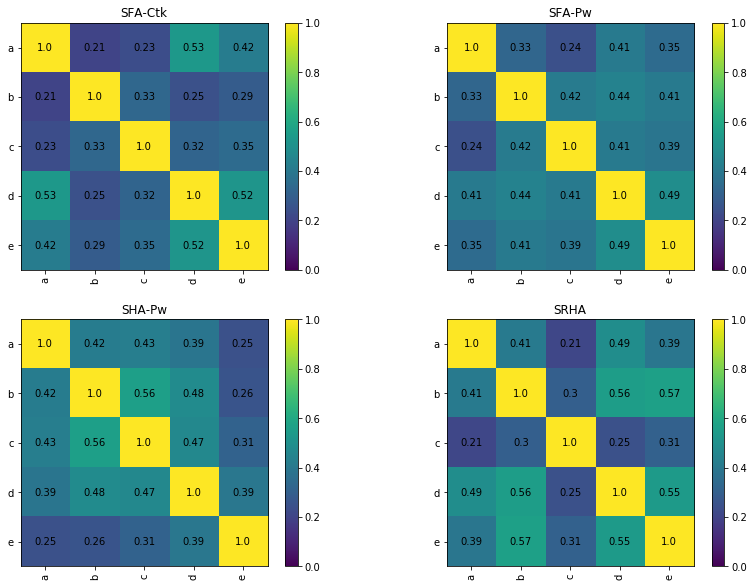

In [14]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data[e][i], data[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

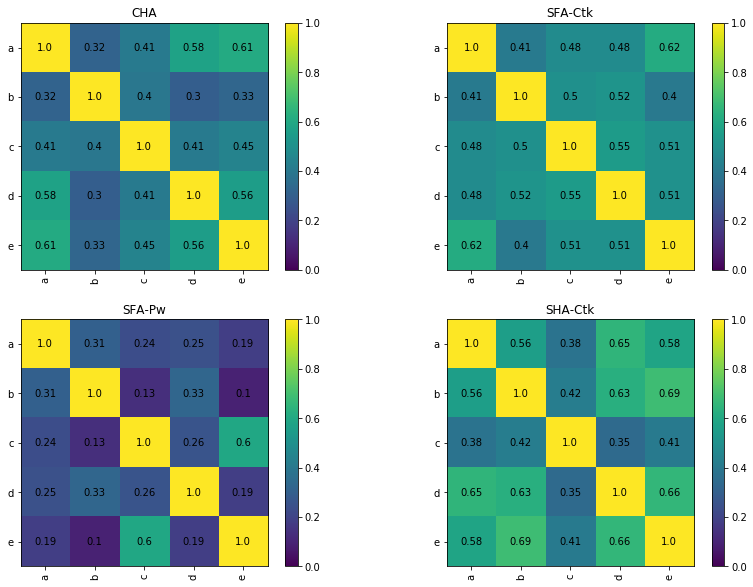

In [15]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(s[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [17]:
models = []
ans = []
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
for t in range(5):
    model = Pipeline([("ss", SS()), ("svm", LR())])
    ans.append([])
    for i in range(4):
        train = filter(lambda x: x != exps[i], exps)
        k = map(lambda x: db[(db["exp"] == x) & (db["town"] == cities[t])], train)
        train = pd.concat(k)

        test = db[(db["exp"] == exps[i]) & (db["town"] == cities[t])]
    
        one = train[train["y"] == 1]
        zer = train[train["y"] == 0]
        print(len(one))
        print(len(zer))
        tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
        model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    
    
        ans[-1].append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
        print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
        print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
        print "test:            ", f1_score(ans[-1][-1], test["y"])

10186
10360
balanced train:   0.847164149737
unbalanced train: 0.84330623837
test:             0.810318331504
10102
8743
balanced train:   0.820808673596
unbalanced train: 0.831519548569
test:             0.755342015425
12276
14196
balanced train:   0.845629965948
unbalanced train: 0.833999680154
test:             0.785333023903
11203
12124
balanced train:   0.835121777461
unbalanced train: 0.826911207125
test:             0.85634103969
9784
2907
balanced train:   0.761564403282
unbalanced train: 0.836281229273
test:             0.860958740758
8229
2354
balanced train:   0.763836079425
unbalanced train: 0.835820895522
test:             0.896353417854
9573
3711
balanced train:   0.826016599676
unbalanced train: 0.871269683956
test:             0.396861719516
8465
2833
balanced train:   0.825033647376
unbalanced train: 0.890772584161
test:             0.844702879024
7111
1214
balanced train:   0.822185061315
unbalanced train: 0.891710118643
test:             0.953652788688
6682
956
balan

In [ ]:
db.exp.unique()
#['CHA', 'SFA-Ctk', 'SFA-Pw', 'SHA-Ctk', 'SHA-Pw', 'SRHA']
#I will not use CHA, SHA-Ctk
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
model = Pipeline([("ss", SS()), ("svm", LR())])

ans = []

for i in range(4):
    train = filter(lambda x: x != exps[i], exps)
    train = pd.concat(list(map(lambda x: db[db["exp"] == x], train)))
    
    one = train[train["y"] == 1]
    zer = train[train["y"] == 0]
    print(len(one))
    print(len(zer))
    tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
    
    
    test = db[db["exp"] == exps[i]]
    
    print "fitting..."
    model.fit(tr.drop(["y", "exp"], axis=1), tr["y"])
    print "scoring..."
    print exps[i]
    
    ans.append(model.predict(test.drop(["y", "exp"], axis=1)))
    
    
    print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp"], axis=1)), tr["y"])
    print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp"], axis=1)), train["y"])
    print "test:            ", f1_score(ans[-1], test["y"])
    
    
    

In [20]:
db["y_pred"] = 0
for i in range(4):
    for t in range(5):
        db.loc[(db["exp"] == exps[i]) & (db["town"] == cities[t]), "y_pred"] = ans[t][i]

In [21]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

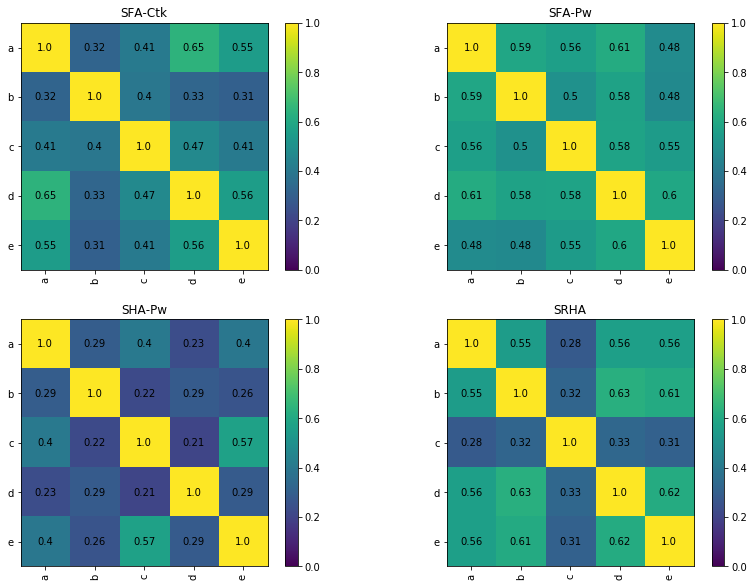

In [23]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [24]:
models = []
ans = []
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
for t in range(5):
    model = Pipeline([("ss", SS()), ("svm", SVC())])
    ans.append([])
    for i in range(4):
        train = filter(lambda x: x != exps[i], exps)
        k = map(lambda x: db[(db["exp"] == x) & (db["town"] == cities[t])], train)
        train = pd.concat(k)

        test = db[(db["exp"] == exps[i]) & (db["town"] == cities[t])]
    
        one = train[train["y"] == 1]
        zer = train[train["y"] == 0]
        print(len(one))
        print(len(zer))
        tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
        model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    
    
        ans[-1].append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
        print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
        print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
        print "test:            ", f1_score(ans[-1][-1], test["y"])

10186
10360
balanced train:   0.887898459452
unbalanced train: 0.885367856625
test:             0.821057288211
10102
8743
balanced train:   0.873649738501
unbalanced train: 0.881491344874
test:             0.785290915689
12276
14196
balanced train:   0.886101314524
unbalanced train: 0.874051233397
test:             0.77416481069
11203
12124
balanced train:   0.875965627984
unbalanced train: 0.868801652893
test:             0.821690140845
9784
2907
balanced train:   0.886086591005
unbalanced train: 0.913641781341
test:             0.884700122399
8229
2354
balanced train:   0.890403251016
unbalanced train: 0.916532595405
test:             0.928126621692
9573
3711
balanced train:   0.893252183117
unbalanced train: 0.919331118253
test:             0.4540302267
8465
2833
balanced train:   0.909865656625
unbalanced train: 0.936867763559
test:             0.732213951878
7111
1214
balanced train:   0.911610540676
unbalanced train: 0.937873975031
test:             0.951282561145
6682
956
balanc

In [25]:
db["y_pred"] = 0
for i in range(4):
    for t in range(5):
        db.loc[(db["exp"] == exps[i]) & (db["town"] == cities[t]), "y_pred"] = ans[t][i]

In [26]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

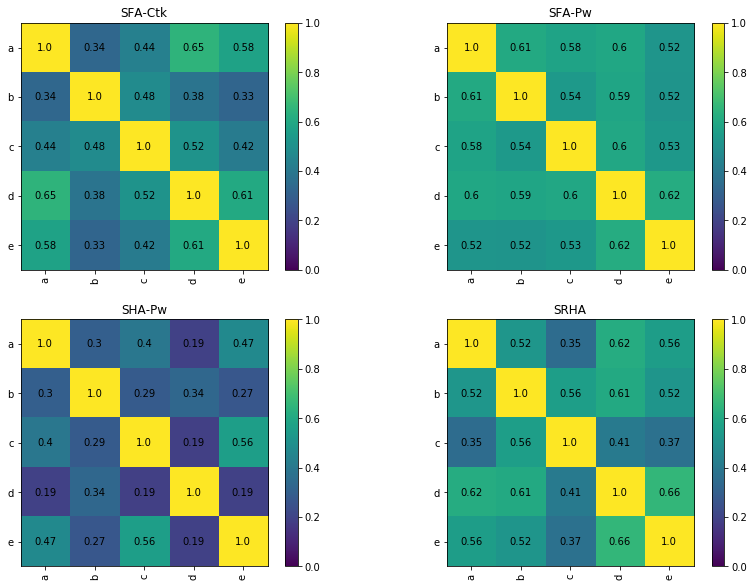

In [27]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})